# Short-Term Electricity Demand Forecasting  
## A Machine Learning Case Study using Australian NEM Data

**Author:** Saiba

---

## Abstract

This project builds a machine learning model to forecast short-term electricity demand
in the Australian National Electricity Market (NEM), focusing on the VIC1 region.

Using publicly available AEMO aggregated demand data, we engineer time-based features and train a Random Forest regression model.

The goal is to evaluate whether historical demand patterns and temporal features alone can produce reliable short-term forecasts.

## 1. Introduction

Electricity demand forecasting is critical for grid reliability and operational efficiency.
The Australian National Electricity Market (NEM) records demand across in 5-min intervals.

Since Electricity cannot be easily stored at large scale, so demand must be predicted accurately to balance supply and prevent instability.

This study investigates whether short-term demand can be predicted using:
- Time-of-day patterns
- Weekly seasonality
- Recent demand history

## 2. Data Description

The dataset is sourced from AEMO's aggregated price and demand files.

Website: https://www.aemo.com.au/energy-systems/electricity/national-electricity-market-nem/data-nem/aggregated-data

Key variables:
- SETTLEMENTDATE: Timestamp of 5-min interval
- REGION: Market region (VIC1)
- TOTALDEMAND: Total electricity load in megawatts (MW)

Each row represents system demand during a specific 5-min trading interval.

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [2]:
DATA_FOLDER = "data/aemo"
CSV_PATTERN = os.path.join(DATA_FOLDER, "PRICE_AND_DEMAND_*.CSV")

TARGET_REGION = "VIC1"
SPLIT_DATE = "2024-10-01"

csv_files = glob.glob(CSV_PATTERN)

if not csv_files:
    raise FileNotFoundError("No CSV files found.")

df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

print(f"Loaded {len(csv_files)} files")
print(f"Total rows: {df.shape[0]}")

# Convert timestamp column to datetime
df["SETTLEMENTDATE"] = pd.to_datetime(df["SETTLEMENTDATE"])

# Ensure chronological order
df = df.sort_values("SETTLEMENTDATE")

df.head()


Loaded 51 files
Total rows: 443520


,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,VIC1,2022-01-01 00:05:00,5005.34,114.80,TRADE
1,VIC1,2022-01-01 00:10:00,4979.22,114.64,TRADE
2,VIC1,2022-01-01 00:15:00,4935.92,112.53,TRADE
3,VIC1,2022-01-01 00:20:00,4878.54,100.44,TRADE
4,VIC1,2022-01-01 00:25:00,4834.30,109.89,TRADE


In [3]:

# 12 intervals = 1 hour
# 288 intervals = 24 hours


# Time-based features
df["hour"] = df["SETTLEMENTDATE"].dt.hour
df["dayofweek"] = df["SETTLEMENTDATE"].dt.dayofweek
df["month"] = df["SETTLEMENTDATE"].dt.month

# Short-term persistence (5 minutes ago)
df["lag1"] = df.groupby("REGION")["TOTALDEMAND"].shift(1)

# Same time yesterday (24 hours ago)
df["lag_288"] = df.groupby("REGION")["TOTALDEMAND"].shift(288)

# Rolling 24-hour mean (288 intervals)
df["rolling_24h"] = (
    df.groupby("REGION")["TOTALDEMAND"]
      .rolling(window=288, min_periods=1)
      .mean()
      .reset_index(level=0, drop=True)
)

# Forward/backward fill missing values created by lagging
df = df.ffill().bfill()

df.head()


,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE,hour,dayofweek,month,lag1,lag_288,rolling_24h
0,VIC1,2022-01-01 00:05:00,5005.34,114.80,TRADE,0,5,1,5005.34,5005.34,5005.340000
1,VIC1,2022-01-01 00:10:00,4979.22,114.64,TRADE,0,5,1,5005.34,5005.34,4992.280000
2,VIC1,2022-01-01 00:15:00,4935.92,112.53,TRADE,0,5,1,4979.22,5005.34,4973.493333
3,VIC1,2022-01-01 00:20:00,4878.54,100.44,TRADE,0,5,1,4935.92,5005.34,4949.755000
4,VIC1,2022-01-01 00:25:00,4834.30,109.89,TRADE,0,5,1,4878.54,5005.34,4926.664000


In [4]:
# Filter for selected region
df_reg = df[df["REGION"] == TARGET_REGION].copy()

# Define features and target
feature_cols = [
    "hour",
    "dayofweek",
    "month",
    "lag1",
    "lag_288",
    "rolling_24h"
]

target_col = "TOTALDEMAND"

# Drop any remaining NaNs
df_reg = df_reg.dropna(subset=feature_cols + [target_col])

print("Rows after filtering:", df_reg.shape[0])


Rows after filtering: 434592


In [5]:
# Time-based split to prevent data leakage
train_df = df_reg[df_reg["SETTLEMENTDATE"] < SPLIT_DATE]
test_df  = df_reg[df_reg["SETTLEMENTDATE"] >= SPLIT_DATE]

print("Training rows:", train_df.shape[0])
print("Test rows:", test_df.shape[0])

# Ensure no overlap
assert train_df["SETTLEMENTDATE"].max() < test_df["SETTLEMENTDATE"].min()


Training rows: 289151
Test rows: 145441


## 7. Model Selection

We use RandomForestRegressor.

Why Random Forest?
- Handles nonlinear relationships
- Robust to scaling issues
- Performs well on structured tabular data
- Interpretable via feature importance

Random forests aggregate multiple decision trees,
reducing variance and improving stability.

In [12]:
model = RandomForestRegressor(
    n_estimators=100,      # reduce trees
    max_depth=15,          # limit tree growth
    n_jobs=-1,             # use all CPU cores
    random_state=42
)

model.fit(train_df[feature_cols], train_df[target_col])

# Predict on unseen test data
test_predictions = model.predict(test_df[feature_cols])

# Compute MAE
mae = mean_absolute_error(test_df[target_col], test_predictions)

print(f"Mean Absolute Error (Test): {mae:.2f} MW")




Mean Absolute Error (Test): 43.84 MW


## Model Training Configuration Rationale

The training parameters were selected to balance model performance with computational efficiency given the large size of 5-minute interval data.

- **n_estimators = 100**  
  A sufficient number of trees to produce stable predictions without unnecessary computational overhead.

- **max_depth = 15**  
  Constrains tree complexity to reduce overfitting and prevent excessively long training times on high-frequency data.

- **n_jobs = -1**  
  Utilises all available CPU cores to improve training speed.

These choices prioritise practical experimentation and reproducibility while maintaining strong predictive capability.

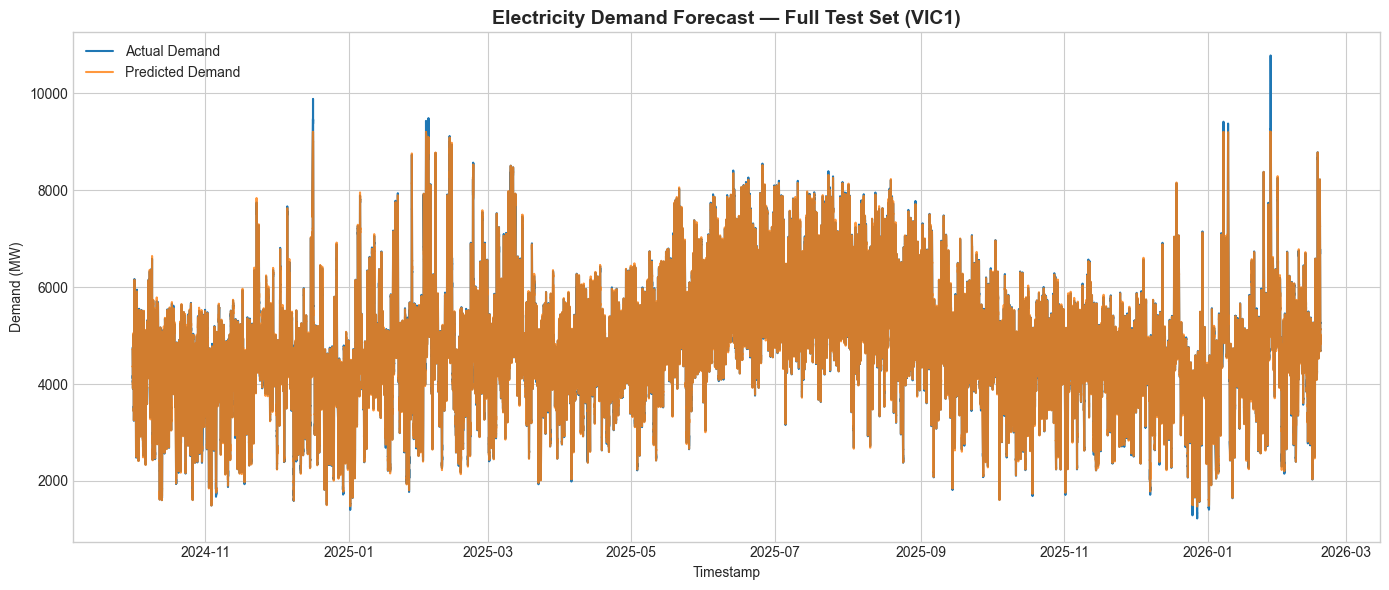

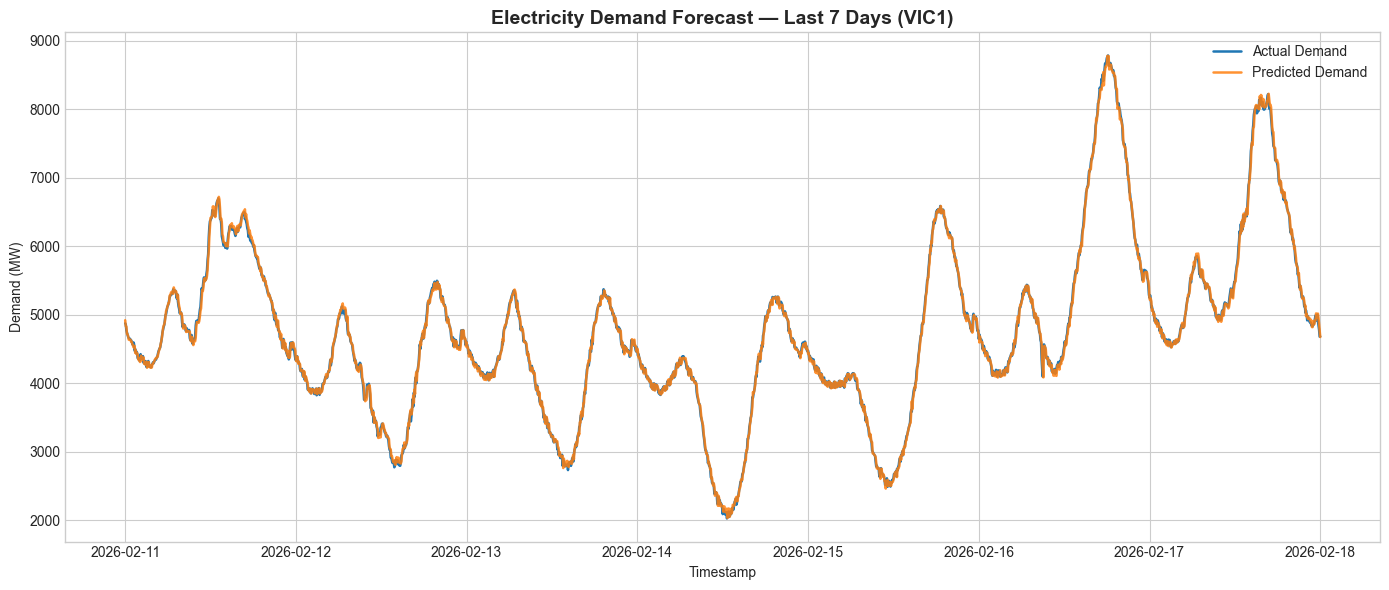

In [9]:
plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(14, 6))

plt.plot(
    test_df["SETTLEMENTDATE"],
    test_df[target_col],
    label="Actual Demand",
    linewidth=1.5
)

plt.plot(
    test_df["SETTLEMENTDATE"],
    test_predictions,
    label="Predicted Demand",
    linewidth=1.5,
    alpha=0.8
)

plt.title(f"Electricity Demand Forecast — Full Test Set ({TARGET_REGION})",
          fontsize=14,
          fontweight="bold")

plt.xlabel("Timestamp")
plt.ylabel("Demand (MW)")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Additional Plot: Last 7 Days of Test Set
# -------------------------------------------------

# Determine last timestamp in test set
end_date = test_df["SETTLEMENTDATE"].max()
start_date = end_date - pd.Timedelta(days=7)

# Filter last 7 days
mask = test_df["SETTLEMENTDATE"] >= start_date
test_last7 = test_df.loc[mask]
pred_last7 = test_predictions[mask]

plt.figure(figsize=(14, 6))

plt.plot(
    test_last7["SETTLEMENTDATE"],
    test_last7[target_col],
    label="Actual Demand",
    linewidth=1.8
)

plt.plot(
    test_last7["SETTLEMENTDATE"],
    pred_last7,
    label="Predicted Demand",
    linewidth=1.8,
    alpha=0.85
)

plt.title(
    f"Electricity Demand Forecast — Last 7 Days ({TARGET_REGION})",
    fontsize=14,
    fontweight="bold"
)

plt.xlabel("Timestamp")
plt.ylabel("Demand (MW)")
plt.legend()
plt.tight_layout()
plt.show()



## 10. Feature Importance Analysis

Random Forest models provide feature importance scores.

This measures how much each feature contributes to reducing prediction error across all decision trees.

The higher the importance, the stronger the influence on predictions.

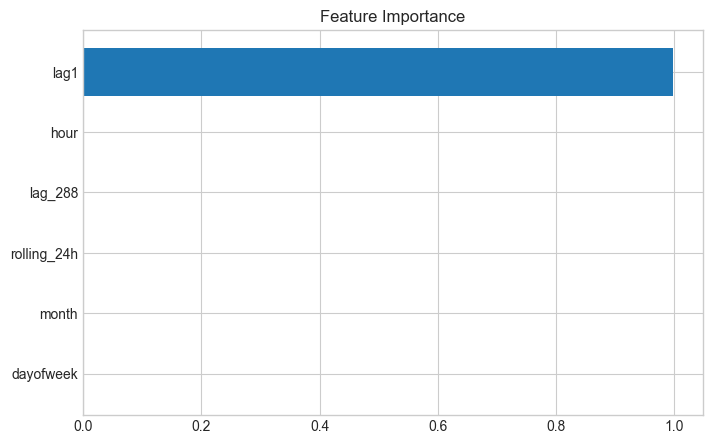

In [10]:
importances = model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": importances
}).sort_values("Importance", ascending=False)

importance_df

plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.show()

## 11. Discussion

Key observations:

- Lag1 is typically highly influential due to demand autocorrelation.
- Hour captures daily peak patterns.
- Rolling_24h captures broader trend behavior.
- Month and dayofweek capture seasonality.

The model demonstrates that simple temporal features
provide strong predictive power for short-term demand.

## 12. Conclusion

This case study demonstrates:

- Proper time-series data handling
- Feature engineering for temporal structure
- Model training and validation without data leakage
- Interpretable feature importance analysis

Future improvements could include:
- Weather data integration
- Holiday indicators
- Gradient boosting models
- Hyperparameter tuning